In [14]:
import os
import sys
import datetime
import glob as glob
import numpy as np
import cv2
import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import layers, models

In [15]:
# default settings
img_width, img_height = 224, 224

train_dir = 'Polyp_copy/train'
validate_dir = 'Polyp_copy/validation'
nb_classes = len(glob.glob(train_dir + '/*'))
epochs = 50
batch_size = 32

In [16]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)

300


In [17]:
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_validate_samples)

100


In [18]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [19]:
# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [20]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 300 images belonging to 2 classes.


In [21]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 100 images belonging to 2 classes.


In [22]:
resnet_model = ResNet50(include_top=False, weights = 'imagenet', input_shape = (img_height, img_width, 3))

2022-10-25 03:01:59.449041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-25 03:01:59.450399: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [23]:
for layer in resnet_model.layers:
    layer.trainable = False

In [24]:
x = layers.Flatten()(resnet_model.output)
prediction = layers.Dense(2, activation='softmax')(x)
model2 = Model(inputs = resnet_model.input, outputs=prediction)

In [25]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [26]:
model2.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [27]:
r = model2.fit(
 train_generator,
 validation_data=validate_generator,
 epochs=epochs,
)

Epoch 1/50


2022-10-25 03:02:05.425651: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-25 03:02:06.839328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 5.3693 - accuracy: 0.5100

2022-10-25 03:02:16.176994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 13s 935ms/step - loss: 5.3693 - accuracy: 0.5100 - val_loss: 8.5789 - val_accuracy: 0.5000
Epoch 2/50
10/10 [==============================] - 8s 831ms/step - loss: 4.1047 - accuracy: 0.5133 - val_loss: 1.9269 - val_accuracy: 0.5000
Epoch 3/50
10/10 [==============================] - 8s 799ms/step - loss: 1.7935 - accuracy: 0.5333 - val_loss: 1.9108 - val_accuracy: 0.5000
Epoch 4/50
10/10 [==============================] - 8s 813ms/step - loss: 1.2767 - accuracy: 0.5033 - val_loss: 1.0201 - val_accuracy: 0.6200
Epoch 5/50
10/10 [==============================] - 8s 793ms/step - loss: 1.2294 - accuracy: 0.6233 - val_loss: 1.8139 - val_accuracy: 0.5900
Epoch 6/50
10/10 [==============================] - 9s 838ms/step - loss: 1.2426 - accuracy: 0.6000 - val_loss: 0.6183 - val_accuracy: 0.7300
Epoch 7/50
10/10 [==============================] - 9s 852ms/step - loss: 0.9662 - accuracy: 0.5700 - val_loss: 0.7259 - val_accuracy: 0.5800
Epoch 8/50
10/10

In [28]:
acc = r.history['accuracy']
val_acc = r.history['val_accuracy']

loss = r.history['loss']
val_loss = r.history['val_loss']


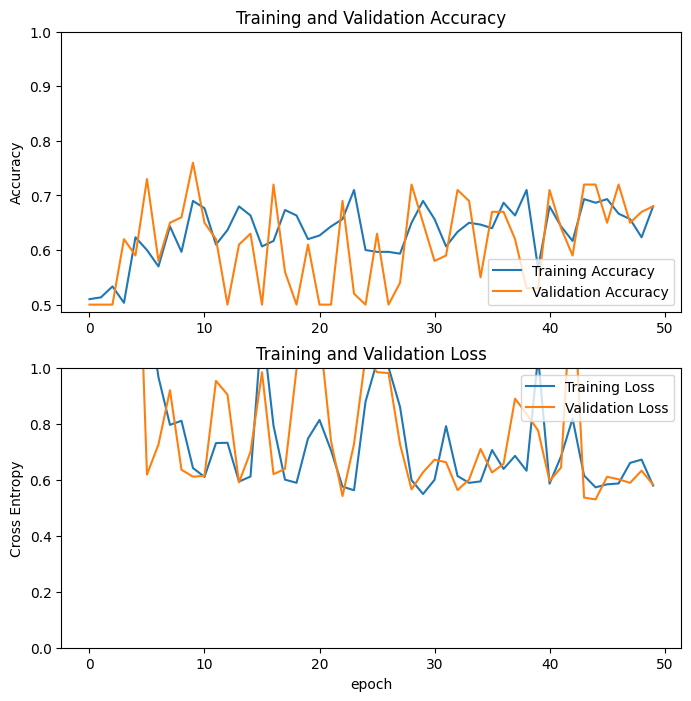

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [30]:
# Fine-tuning - change weights for all layers except the first one
fine_tune_at = 1
for layer in model2.layers[:fine_tune_at]:
    layer.trainable = False

In [31]:
model2.compile(loss='categorical_crossentropy',
              optimizer = 'Adam',
              metrics=['accuracy'])

In [32]:
fine_tune_epochs = 20
total_epochs = epochs + fine_tune_epochs
history_fine = model2.fit(train_generator,
                             epochs=total_epochs,
                             initial_epoch=r.epoch[-1],
                             validation_data=validate_generator)

Epoch 50/70


2022-10-25 03:07:59.717307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 5.1708 - accuracy: 0.5200

2022-10-25 03:08:04.134960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 8s 575ms/step - loss: 5.1708 - accuracy: 0.5200 - val_loss: 4.6010 - val_accuracy: 0.5600
Epoch 51/70
10/10 [==============================] - 5s 457ms/step - loss: 2.5132 - accuracy: 0.5167 - val_loss: 1.2806 - val_accuracy: 0.6000
Epoch 52/70
10/10 [==============================] - 5s 475ms/step - loss: 1.0053 - accuracy: 0.6333 - val_loss: 1.0111 - val_accuracy: 0.5100
Epoch 53/70
10/10 [==============================] - 5s 500ms/step - loss: 0.8777 - accuracy: 0.5933 - val_loss: 0.5912 - val_accuracy: 0.7300
Epoch 54/70
10/10 [==============================] - 5s 480ms/step - loss: 0.5816 - accuracy: 0.7233 - val_loss: 0.5603 - val_accuracy: 0.7300
Epoch 55/70
10/10 [==============================] - 5s 476ms/step - loss: 0.5476 - accuracy: 0.7233 - val_loss: 0.5973 - val_accuracy: 0.7100
Epoch 56/70
10/10 [==============================] - 5s 496ms/step - loss: 0.5792 - accuracy: 0.7333 - val_loss: 0.5765 - val_accuracy: 0.7200
Epoch 57/70

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


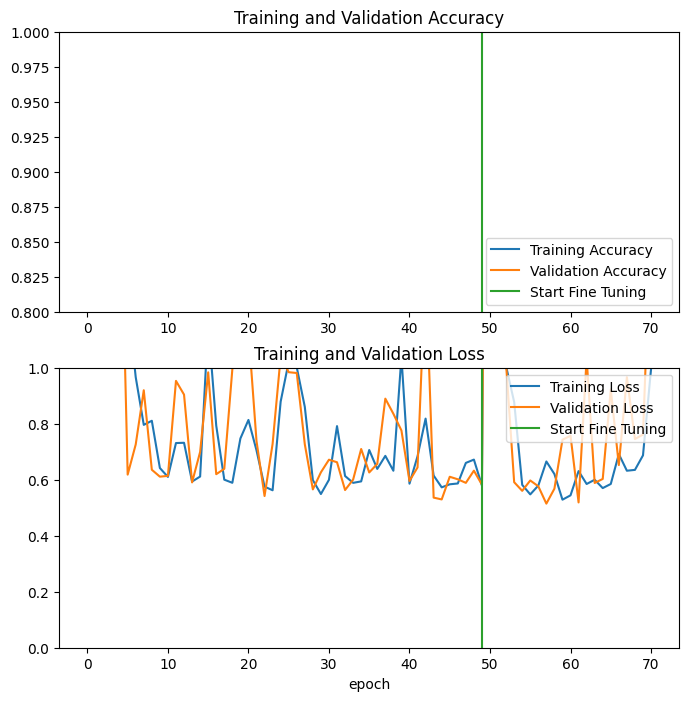

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([epochs-1,epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([epochs-1,epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [35]:
loss, accuracy = model2.evaluate(validate_generator)
print('Test accuracy :', accuracy)

4/4 [==============================] - 1s 231ms/step - loss: 1.5505 - accuracy: 0.5900
Test accuracy : 0.5899999737739563
